# synthetic validation


## 1. Real photocurrent, real PSCs

In [1]:
import h5py 
import numpy as np
import matplotlib.pyplot as plt


import subtractr
import subtractr.photocurrent_sim as pcsim
import subtractr.psc_sim as psc_sim
import jax.random as jrand

import circuitmap as cm
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec

from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.gridspec import GridSpec
from subtractr import utils
from functools import partial
from jax import vmap

In [8]:

# load subtractr net
# st_checkpoint = './grid_artifacts/cunning-brattain-9345/cunning-brattain-9345-exp0/scripts/lightning_logs/version_0/checkpoints/epoch=127-step=360063.ckpt'

# st_net = cm.NeuralDemixer(
#     path=st_checkpoint,
#     unet_args=dict(
#             down_filter_sizes=(16, 32, 64, 128),
#             up_filter_sizes=(64, 32, 16, 4),
#     ))

net = subtractr.Subtractr.load_from_checkpoint('../subtractr/lightning_logs/version_500470/checkpoints/epoch=786-val_loss=0.00023550465994048864_best_val.ckpt')

# load demixer
demixer_checkpoint = '../../circuit_mapping/demixers/nwd_ee_ChroME1.ckpt'
demixer = cm.NeuralDemixer(
    path=demixer_checkpoint,
)

In [9]:
from scipy.stats import multivariate_normal


def make_spatial_opsin_resp(targets,
    powers,
    stim_mat,
    phi_0=0.1,
    phi_1=35,
    opsin_loc=None):

    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    unique_powers = np.unique(powers)
    unique_tars = np.unique(targets, axis=0)

    num_xs = len(np.unique(unique_tars[:,0]))
    num_ys = len(np.unique(unique_tars[:,1]))
    num_zs = len(np.unique(unique_tars[:,2]))

    if opsin_loc is None:
        opsin_resp_centroid = np.mean(unique_tars, axis=0)
    else:
        opsin_resp_centroid = opsin_loc
    opsin_resp_cov = np.diag([100, 100, 400])
 
    rv = multivariate_normal(opsin_resp_centroid, opsin_resp_cov)

    opsin_resp = np.zeros(stim_mat.shape[1])
    for trial in range(stim_mat.shape[1]):
        neurons_this_trial = np.where(stim_mat[:, trial])[0]
        for neuron_idx in neurons_this_trial:
            xyz = targets[neuron_idx]
            p = powers[trial]
            opsin_resp[trial] += rv.pdf(xyz) * phi_0 * sigmoid(p - phi_1)

    opsin_resp /= np.max(opsin_resp)
    return opsin_resp

def make_hybrid_spatial_dataset(key,
    pscs,
    targets,
    powers,
    stim_mat,
    templates_path=None,
    opsin_std_dev=0.1,
    pc_shape_params=None,
    onset_latency_ms=0.0,
    onset_jitter_ms=0.2,
    opsin_scale=0.8,
    opsin_loc=None,
    response_cutoff=0.1):

    if pc_shape_params is None:
        pc_shape_params = dict(
           O_inf_min=0.3,
            O_inf_max=1.0,
            R_inf_min=0.3,
            R_inf_max=1.0,
            tau_o_min=7,
            tau_o_max=7,
            tau_r_min=26,
            tau_r_max=29, 
        )

    # grab photocurrent shape from templates
    if templates_path is not None:
        with h5py.File(templates_path) as F:
            templates = np.array(F['traces'])

        photocurrent_waveforms = np.squeeze(
            subtractr.photocurrent_sim.sample_from_templates(
                templates,
                key,
                size=1,
            )
        )
    else:
        # sample a bunch of photocurrent waveforms with the same shape,
        # but with slight jitter
        photocurrent_waveforms = np.array(pcsim.sample_jittered_photocurrent_shapes(
            key,
            num_traces=pscs.shape[0],
            linear_onset_frac=0.0,
            pc_shape_params = pc_shape_params,
            onset_jitter_ms=onset_jitter_ms,
            onset_latency_ms=onset_latency_ms,
        )[1])
        
        

    # create spatial opsin response
    average_opsin_resp = make_spatial_opsin_resp(targets,
        powers, stim_mat, opsin_loc=opsin_loc) * opsin_scale

    # sample from normal modulated by space and power
    opsin_scales = np.random.normal(loc=average_opsin_resp, scale=opsin_std_dev)

    # truncate so that we don't have small photocurrents where the mean response
    # is below a cutoff
    idxs_cutoff = (average_opsin_resp < response_cutoff)
    opsin_scales[idxs_cutoff] = 0.0

    # be lazy instead of sampling from truncated normal distribution
    # shouldn't matter too much here
    opsin_scales = np.maximum(0, opsin_scales)
    scaled_photocurrents = photocurrent_waveforms * opsin_scales[:,None]

    pscs_plus_photo = pscs + scaled_photocurrents

    return pscs_plus_photo, scaled_photocurrents, photocurrent_waveforms

def make_synth_psc_dataset(
    key,
    num,
    templates_path,
    photocurrent_scale_min,
    photocurrent_scale_max,
    psc_scale_min,
    psc_scale_max,
    psc_latency_min,
    psc_latency_max,
    onset_latency_ms=0.0,
    onset_jitter_ms=0.2,
    msecs_per_sample=0.05):

    # grab photocurrent shape from templates
    with h5py.File(templates_path) as F:
        templates = np.array(F['traces'])

    # photocurrent_waveform = np.squeeze(
    #     subtractr.photocurrent_sim.sample_from_templates(
    #         templates,
    #         key,
    #         size=1,
    #     )
    # )
    template_idx = np.random.randint(templates.shape[0])
    photocurrent_waveform = templates[template_idx]

        
    # sample from normal modulated by space and power
    photocurrent_scales = np.random.uniform(low=photocurrent_scale_min, high=photocurrent_scale_max, size=num)
    psc_scales = np.random.uniform(low=psc_scale_min, high=psc_scale_max, size=num)

    # sample pscs
    psc_keys = jrand.split(key, num=num)
    psc_sampler_fun = vmap(
        partial(
            psc_sim._sample_psc_kernel,
            trial_dur=900, tau_r_lower=10, tau_r_upper=80, tau_diff_lower=50,
            tau_diff_upper=150, delta_lower= 1 / msecs_per_sample * psc_latency_min, delta_upper=1 / msecs_per_sample * psc_latency_max,
            max_samples=1, n_samples_active=1, amplitude_lower=psc_scale_min, amplitude_upper=psc_scale_max
        )
    )
    pscs = np.squeeze(psc_sampler_fun(psc_keys))

    photocurrents = photocurrent_waveform[None,:] * photocurrent_scales[:,None]
    pscs_plus_photo = pscs + photocurrents

    return pscs_plus_photo, photocurrents, pscs


In [10]:


pscs, stim_mat, powers, targets = utils.load_h5_data('../data/marta/ai203/preprocessed/201119_cell7_A_cmFormat.mat')
pscs = -pscs

# get rid of everything except the top plane
targets_per_trial = np.row_stack([targets[np.where(x)[0]] for x in stim_mat.T])
plane_zero_idxs = targets_per_trial[:,-1] == -75

pscs = pscs[plane_zero_idxs]
stim_mat = stim_mat[:,plane_zero_idxs]
powers = powers[plane_zero_idxs]
targets = targets[targets[:,-1] == -75]

# make psc tensor
psc_tensor = utils.make_psc_tensor_multispot(pscs, powers, targets, stim_mat)



In [11]:


key = jrand.PRNGKey(1)

# grab photocurrent shape from templates
templates_path = 'pc_examples_fastdecay.h5'
pscs_plus_photo, scaled_photocurrents, photocurrent_waveform = make_hybrid_spatial_dataset(
    key, pscs, targets, powers, stim_mat, templates_path=None,
    opsin_scale=0.5, opsin_loc=[200, 250, -75],
    response_cutoff=0.01,
)


In [12]:

photocurent_tensor = utils.make_psc_tensor_multispot(scaled_photocurrents, powers, targets, stim_mat)
combined_tensor = utils.make_psc_tensor_multispot(pscs_plus_photo, powers, targets, stim_mat)
combined_map = utils.traces_tensor_to_map(combined_tensor)
original_map = utils.traces_tensor_to_map(psc_tensor)


In [23]:
# mt_net = subtractr.Subtractr.load_from_checkpoint('../subtractr/lightning_logs/version_494457/checkpoints/epoch=219-step=687500.ckpt')
# ests = mt_net(pscs_plus_photo)

# ests = utils.denoise_pscs_in_batches(pscs_plus_photo, net)
# ests = net(pscs_plus_photo)
ests = subtractr.low_rank.estimate_photocurrents_by_batches(pscs_plus_photo, rank=1, constrain_V=True, batch_size=100, )
subtracted = pscs_plus_photo - ests
demixed_estimate = utils.denoise_pscs_in_batches(subtracted, demixer)
demixed_original = utils.denoise_pscs_in_batches(pscs, demixer)


corrected_tensor = utils.make_psc_tensor_multispot(subtracted, powers, targets, stim_mat)
corrected_map = utils.traces_tensor_to_map(corrected_tensor)

demixed_estimate_tensor = utils.make_psc_tensor_multispot(demixed_estimate, powers, targets, stim_mat)
demixed_estimate_map = utils.traces_tensor_to_map(demixed_estimate_tensor)

demixed_original_tensor = utils.make_psc_tensor_multispot(demixed_original, powers, targets, stim_mat)
demixed_original_map = utils.traces_tensor_to_map(demixed_original_tensor)

Running photocurrent estimation with 162 batches...


100%|██████████| 162/162 [00:40<00:00,  3.99it/s]


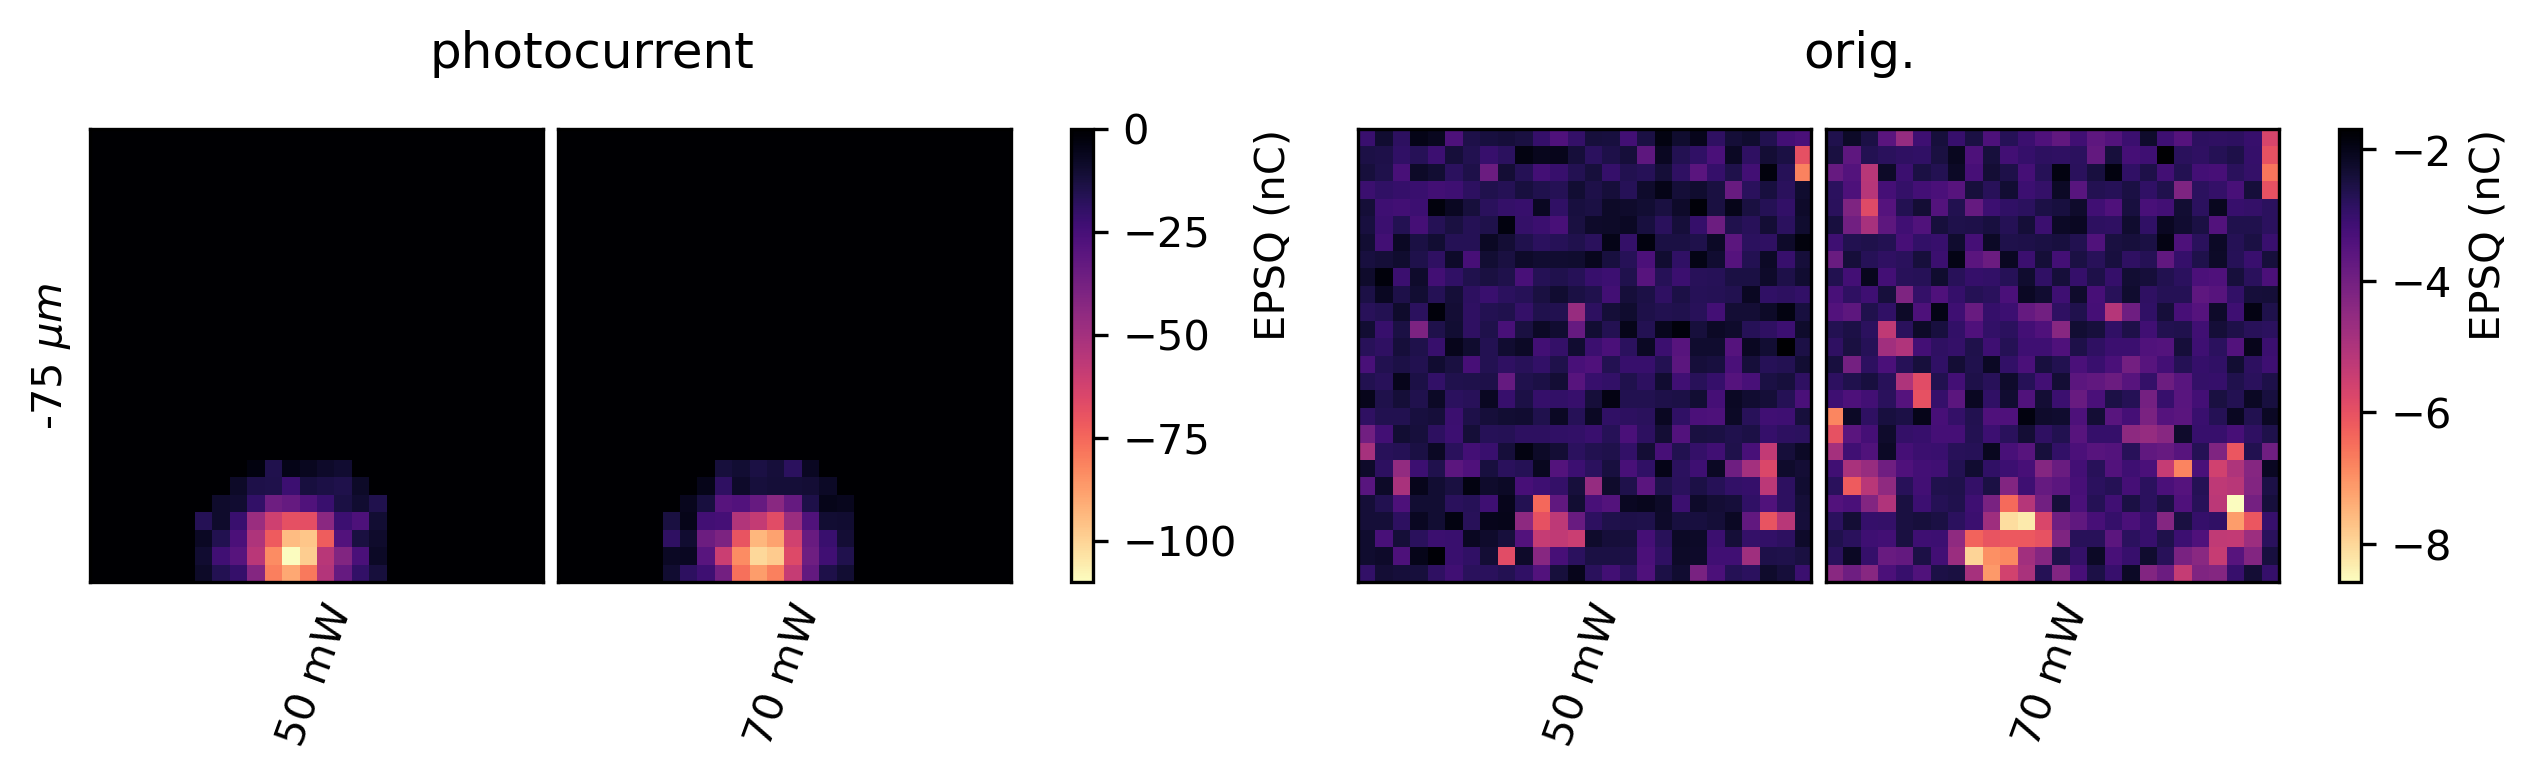

In [24]:
# figure to show how the corrupt map was created
photocurrent_map = utils.traces_tensor_to_map(photocurent_tensor)
fig1 = plt.figure(figsize=(10, 2), dpi=300, facecolor='white')
utils.plot_multi_means(fig1,
    [-photocurrent_map, -original_map], 
    np.arange(1),
    cmaps=['magma_r', 'magma_r', 'magma_r', 'magma'],
    cbar_labels=['EPSQ (nC)']*3,
    # zlabels=['subtr', 'demix'],
    map_names=['photocurrent', 'orig.', 'g.t'],
    # vranges=[(0,10), (0,5), (0,5), (0,5)],
    show_powers=(True, True, True, True),
    powers=np.unique(powers),
    zs = np.unique(targets),
)

/var/folders/67/j86q1s2s1_dg5m568j2k9d040000gn/T/ipykernel_14718/1919999899.py:14: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


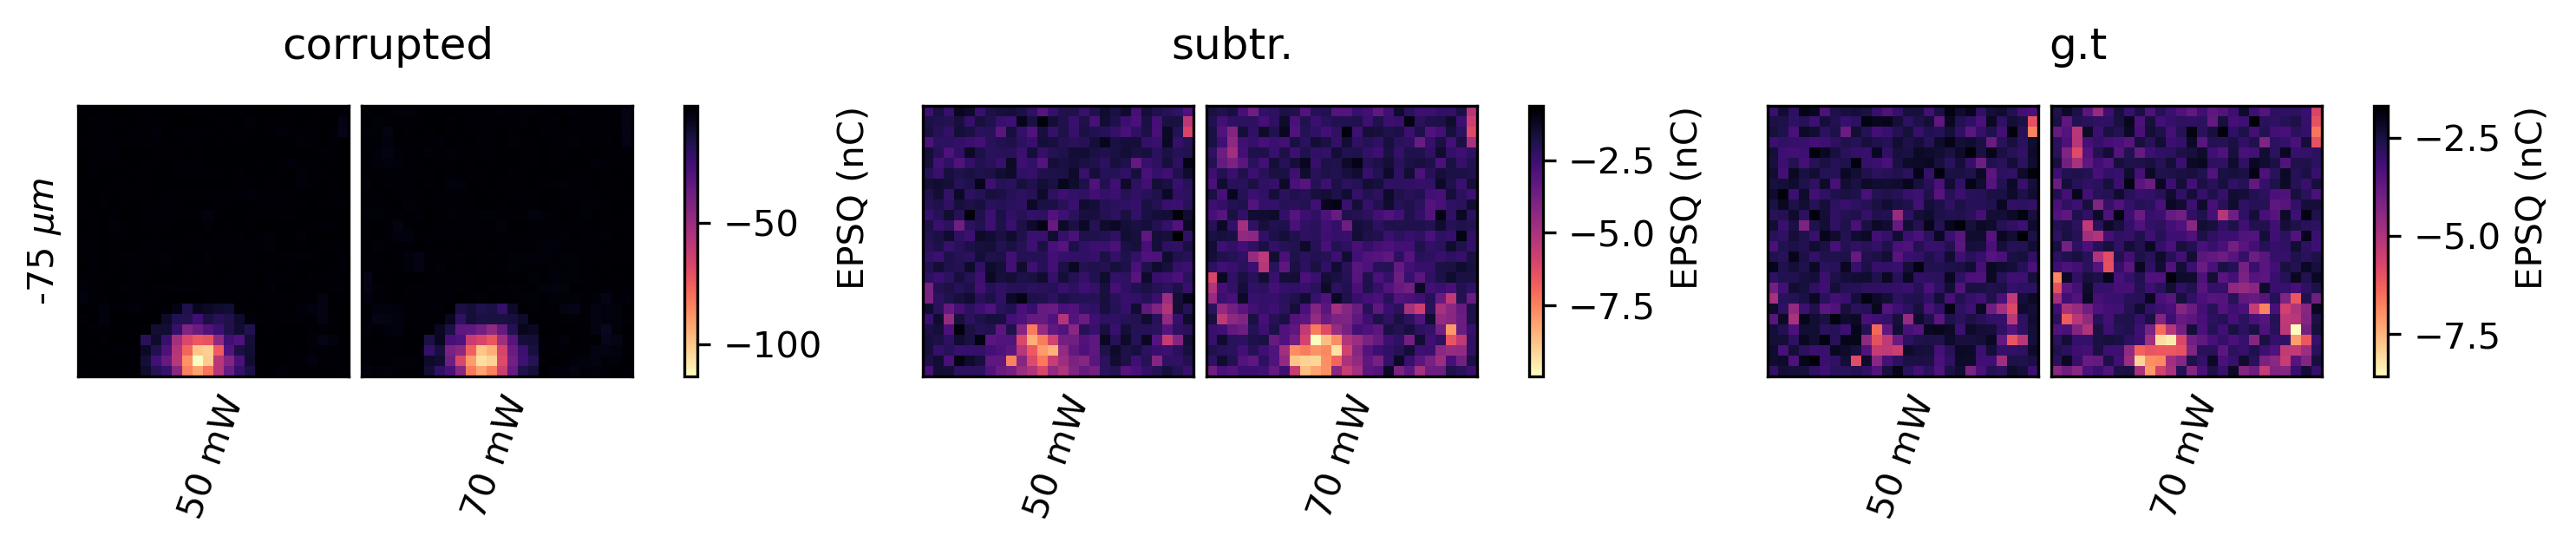

In [28]:
fig1 = plt.figure(figsize=(10, 2), dpi=300, facecolor='white')
utils.plot_multi_means(fig1,
    [-combined_map, -corrected_map, -original_map], 
    np.arange(1),
    cmaps=['magma_r', 'magma_r', 'magma_r', 'magma_r'],
    cbar_labels=['EPSQ (nC)']*3,
    # zlabels=['subtr', 'demix'],
    map_names=['corrupted', 'subtr.', 'g.t'],
    # vranges=[(-20,0), (-10,0), (-10,0), (0,10)],
    show_powers=(True, True, True, True),
    powers=np.unique(powers),
    zs = np.unique(targets),
)
plt.tight_layout()

In [26]:
def plot_subtraction_synthetic(pscs, ests, subtracted, photocurrents, powers,
    orig_pscs=None, time=None, fig_kwargs=None):

    if fig_kwargs is None:
        fig_kwargs = dict(
            figsize=(9,3), 
            dpi=200,
            sharex=True
        )
    unique_powers = np.unique(powers)
    fig, axs = plt.subplots(nrows=len(unique_powers), ncols = 4, squeeze=False, **fig_kwargs)

    if time is None:
        time = np.arange(0,900) * 0.05
    for i in range(len(unique_powers)):
        these_trials = (powers == unique_powers[i])
        these_pscs = pscs[these_trials]
        these_ests = ests[these_trials]
        these_subtracted = subtracted[these_trials]
        these_photocurrents = photocurrents[these_trials]

        # order each by magnitude of photocurrent
        if orig_pscs is None:
            ordered_idx = np.argsort(np.sum(these_pscs, axis=-1))[::-1]
        else:
            these_orig_pscs = orig_pscs[these_trials]
            ordered_idx = np.argsort(np.sum(these_orig_pscs, axis=-1))[::-1]
            these_orig_pscs = these_orig_pscs[ordered_idx]
            
        these_pscs = these_pscs[ordered_idx]
        these_ests = these_ests[ordered_idx]
        these_photocurrents = these_photocurrents[ordered_idx]

        these_subtracted = these_subtracted[ordered_idx]

        axs[i,0].plot(time, these_pscs[0:20].T)
        axs[i,1].plot(time, these_ests[0:20].T)
        if orig_pscs is not None:
            axs[i,2].plot(time, these_orig_pscs[0:20].T)
        else:
            axs[i,2].plot(time, these_photocurrents[0:20].T)
        axs[i,3].plot(time, these_subtracted[0:20].T)

        # make ylim of first two plots match
        axs[i,1].set_ylim(axs[i,0].get_ylim())
        # axs[i,3].set_ylim(axs[i,2].get_ylim())
        axs[i,0].set_ylabel('%d mW' % unique_powers[i])

    labels = ['raw', 'est pc', 'True PSCs', 'Est PSCs']
    for i in range(4):
        axs[-1, i].set_xlabel('time (ms)')
        axs[0, i].set_title(labels[i])

    plt.tight_layout()
    return fig

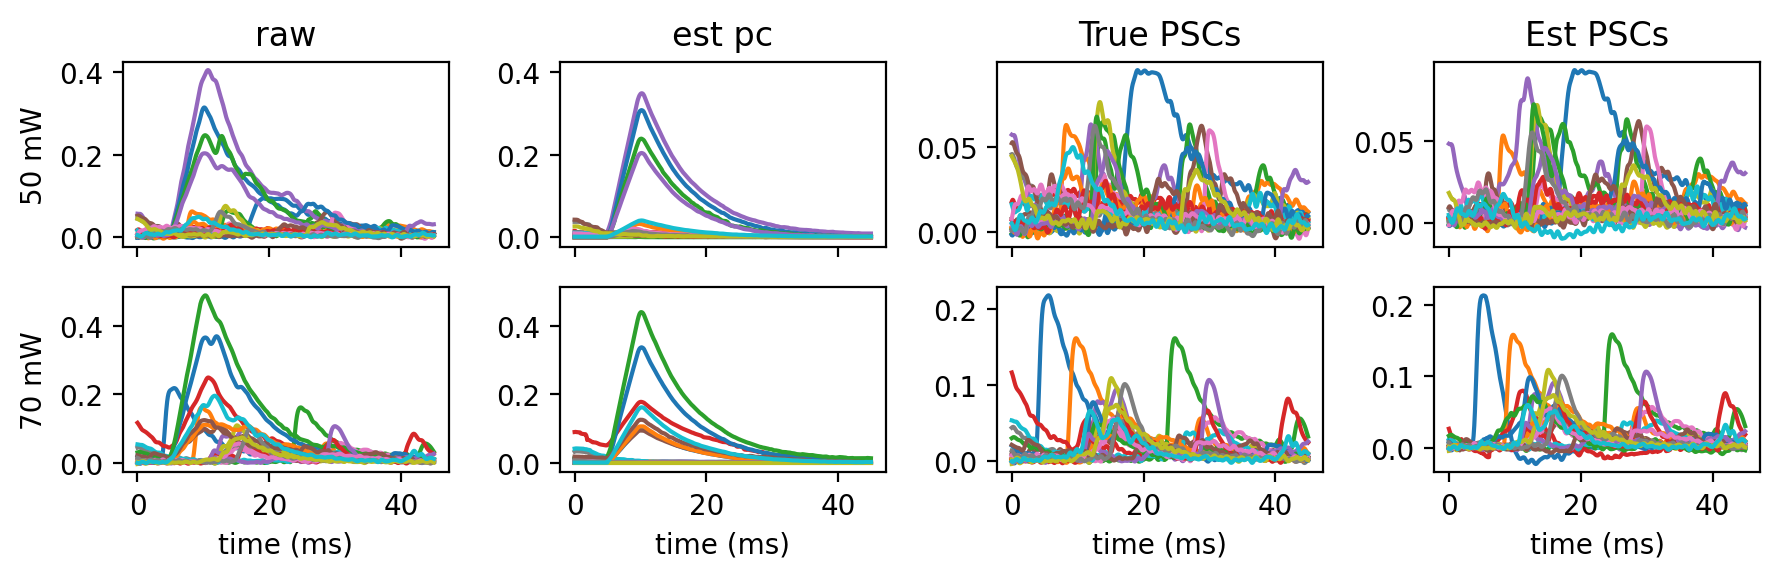

In [27]:
fig = plot_subtraction_synthetic(pscs_plus_photo, ests, subtracted,
    scaled_photocurrents, powers, orig_pscs=pscs)

## Evaluate with low-latency PSCs on curated photocurrent examples

In [310]:

def get_mse(psc_latency, net, tstart_ms=5, tend_ms=38, msecs_per_sample=0.05):
    pscs_plus_photo, photocurrents, pscs = make_synth_psc_dataset(
        key,
        32,
        templates_path,
        photocurrent_scale_min=0.5,
        photocurrent_scale_max=1.5,
        psc_scale_min=0.01,
        psc_scale_max=0.1,
        psc_latency_min=psc_latency,
        psc_latency_max=psc_latency,
        onset_latency_ms=0.0,
        onset_jitter_ms=0.1,
        msecs_per_sample=msecs_per_sample,
    )
    pscs_plus_photo = np.array(pscs_plus_photo)
    photocurrents = np.array(photocurrents)

    ests = net(pscs_plus_photo)
    subtracted = pscs_plus_photo - ests

    idx_start = int(np.round(1 / msecs_per_sample * tstart_ms))
    idx_end = int(np.round(1 / msecs_per_sample * tend_ms))
    mse = np.linalg.norm(subtracted[:, idx_start:idx_end]
        - pscs[:, idx_start:idx_end]) / np.linalg.norm(pscs[:, idx_start:idx_end])
    return mse

    

pscs_plus_photo, photocurrents, pscs = make_synth_psc_dataset(
    key,
    32,
    templates_path,
    photocurrent_scale_min=1.5,
    photocurrent_scale_max=0.5,
    psc_scale_min=0.01,
    psc_scale_max=0.1,
    psc_latency_min=11,
    psc_latency_max=11,
    onset_latency_ms=0.0,
    onset_jitter_ms=0.2,
    msecs_per_sample=0.05
)
pscs_plus_photo = np.array(pscs_plus_photo)
photocurrents = np.array(photocurrents)
pscs = np.array(pscs)

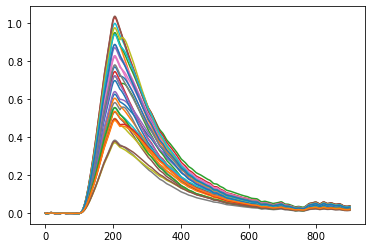

In [311]:
plt.plot(pscs_plus_photo.T)
plt.show()

In [316]:
ests = st_net(pscs_plus_photo)
subtracted = pscs_plus_photo - ests

Demixing PSC traces... complete (elapsed time 0.09s, device=cpu).


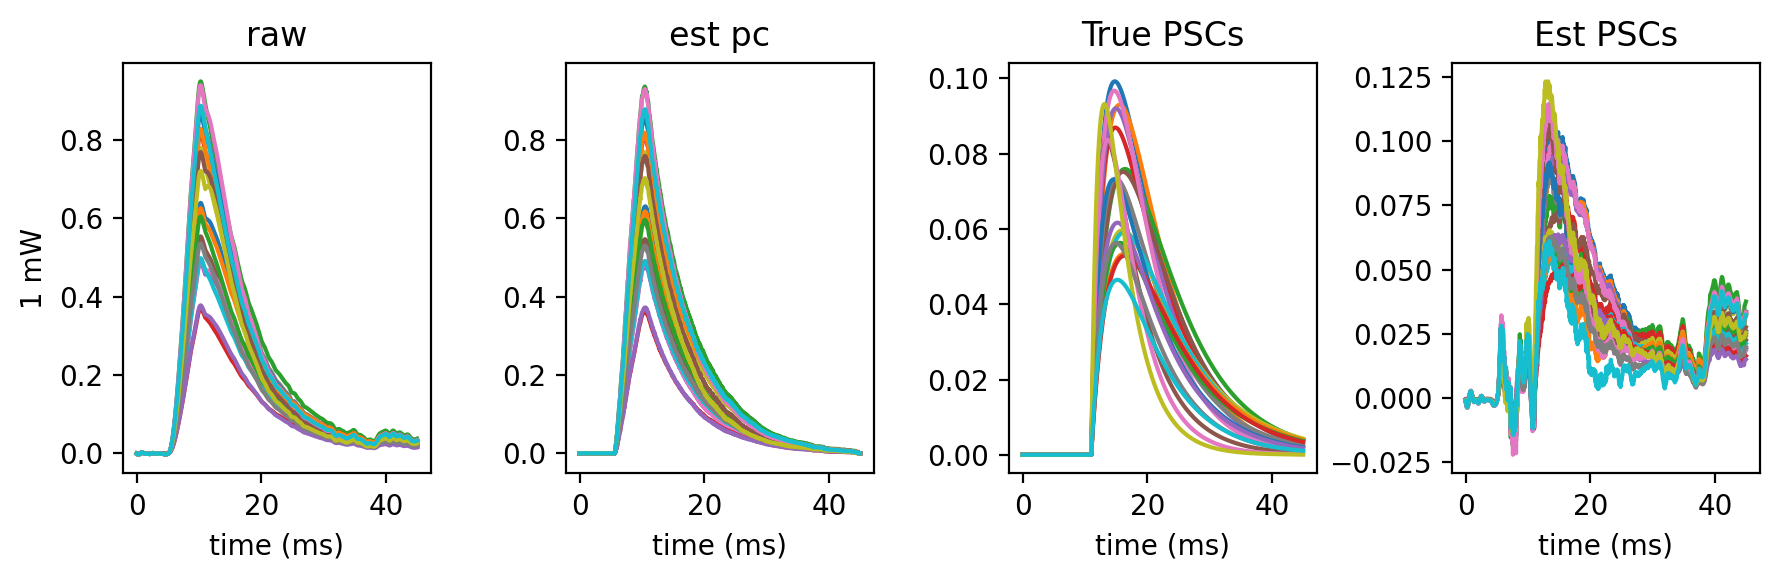

In [317]:
plot_subtraction_synthetic(pscs_plus_photo, ests, subtracted, photocurrents, powers=np.ones(pscs.shape[0]), orig_pscs=pscs)
plt.show()

In [314]:
latencies = np.arange(6,20)
num_repeats = 50
st_mse = np.zeros((num_repeats, len(latencies)))
mt_mse = np.zeros((num_repeats, len(latencies)))
for j, latency in enumerate(latencies):
    for i in range(num_repeats):
        st_mse[i, j] = get_mse(latency, st_net)
        mt_mse[i, j] = get_mse(latency, net)

Demixing PSC traces... complete (elapsed time 0.09s, device=cpu).
Running photocurrent removal...complete (elapsed time 0.12s, device=cpu).
Demixing PSC traces... complete (elapsed time 0.09s, device=cpu).
Running photocurrent removal...complete (elapsed time 0.11s, device=cpu).
Demixing PSC traces... complete (elapsed time 0.10s, device=cpu).
Running photocurrent removal...complete (elapsed time 0.10s, device=cpu).
Demixing PSC traces... complete (elapsed time 0.09s, device=cpu).
Running photocurrent removal...complete (elapsed time 0.10s, device=cpu).
Demixing PSC traces... complete (elapsed time 0.13s, device=cpu).
Running photocurrent removal...complete (elapsed time 0.11s, device=cpu).
Demixing PSC traces... complete (elapsed time 0.10s, device=cpu).
Running photocurrent removal...complete (elapsed time 0.11s, device=cpu).
Demixing PSC traces... complete (elapsed time 0.10s, device=cpu).
Running photocurrent removal...complete (elapsed time 0.11s, device=cpu).
Demixing PSC traces.

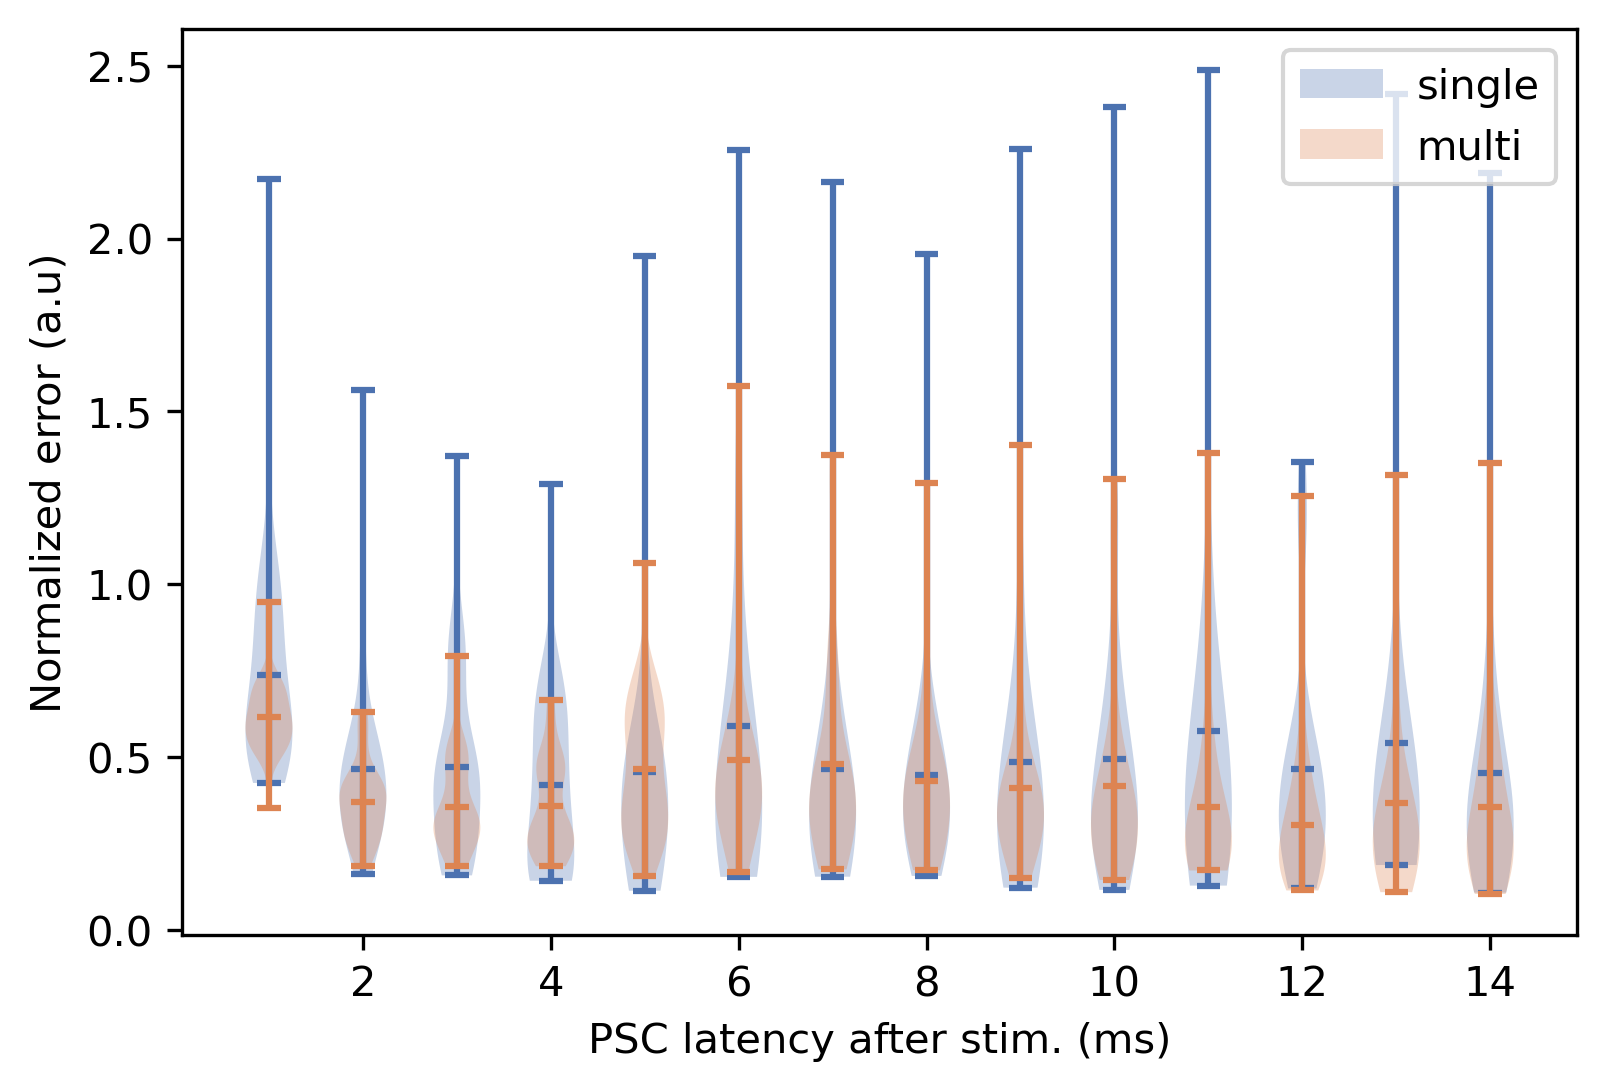

In [318]:
import seaborn as sns
with sns.color_palette(palette='deep'):

    plt.figure(dpi=300, facecolor='white')
    # bplot1 = plt.boxplot(st_mse, vert=True, patch_artist=True, showfliers=False, labels=latencies)
    # bplot2 = plt.boxplot(mt_mse, vert=True, patch_artist=True, showfliers=False, labels=latencies)
    bplot1 = plt.violinplot(st_mse, showmeans=True, positions=latencies-5)
    bplot2 = plt.violinplot(mt_mse, showmeans=True, positions=latencies-5)

    # # fill with colors
    # colors = ['red', 'blue',]
    # for bplot, color in zip((bplot1, bplot2), colors):
    #     for patch in bplot['boxes']:
    #         patch.set_facecolor(color)



    # colors = ['red', 'blue',]
    # for vplot, color in zip((bplot1, bplot2,), colors):
    #     for violin in vplot:
    #         vplot['bodies'].set_color(color)
    #         vplot['cbars'].set_color(color)

    plt.legend([bplot1["bodies"][0], bplot2["bodies"][0]],
            ['single', 'multi'],
            bbox_to_anchor=(1, 1))

    plt.xlabel('PSC latency after stim. (ms)')
    plt.ylabel('Normalized error (a.u)')
    plt.show()

In [252]:
bplot1.keys()

dict_keys(['bodies', 'cmaxes', 'cmins', 'cbars'])